In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import label_binarize, StandardScaler
from scipy.ndimage import shift, rotate

Reading data

In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist.data, mnist.target
X = X / 255.0
X = X.reshape(-1, 28, 28)

Function for data augmentation

In [ ]:
def augment_image(image):
    augmented_images = []

    # Shift directions: up, down, left, right
    shifts = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    for shift_dir in shifts:
        shifted_image = shift(image, shift=shift_dir, mode='constant', cval=0)
        augmented_images.append(shifted_image)

    # Rotate: 15 degrees clockwise and counterclockwise
    rotated_image1 = rotate(image, 15, reshape=False, mode='constant', cval=0)
    rotated_image2 = rotate(image, -15, reshape=False, mode='constant', cval=0)
    augmented_images.extend([rotated_image1, rotated_image2])
    return augmented_images

Batch wise augmentation

In [ ]:
def batch_augment(X, y, batch_size=1000):
    X_augmented = []
    y_augmented = []

    for start in range(0, len(X), batch_size):
        end = min(start + batch_size, len(X))
        X_batch = X[start:end]
        y_batch = y[start:end]

        for i in range(len(X_batch)):
            augmented_images = augment_image(X_batch[i])
            X_augmented.extend(augmented_images)
            y_augmented.extend([y_batch[i]] * len(augmented_images))

    return np.array(X_augmented), np.array(y_augmented)

Combining original and augmented data

In [ ]:
X_augmented, y_augmented = batch_augment(X, y)

X = X.reshape(-1, 28*28)
X_augmented = X_augmented.reshape(-1, 28*28)

X_combined = np.vstack((X, X_augmented))
y_combined = np.concatenate((y, y_augmented))

In [ ]:
X = pd.DataFrame(X_combined, columns = mnist.feature_names)
Y = pd.DataFrame(y_combined, columns = ['target']).astype(int)

Undersampling

In [ ]:
target_sample_size = 20000

undersampled_indices = []

for target_class in range(10):
    class_indices = Y[Y['target'] == target_class].index
    undersampled_class_indices = np.random.choice(class_indices, target_sample_size, replace=False)
    undersampled_indices.extend(undersampled_class_indices)

undersampled_indices = np.array(undersampled_indices)

X_undersampled = X.loc[undersampled_indices].reset_index(drop=True)
Y_undersampled = Y.loc[undersampled_indices].reset_index(drop=True)

Y_undersampled['target'].value_counts()

target
0    20000
1    20000
2    20000
3    20000
4    20000
5    20000
6    20000
7    20000
8    20000
9    20000
Name: count, dtype: int64

In [ ]:
X_undersampled.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.397765e-09,1.576079e-08,-5.144246e-08,6.837794e-08,1.425576e-07,-1.027012e-06,...,-1.623684e-04,4.925327e-04,3.139712e-04,-1.961132e-04,5.851822e-05,-5.553760e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,-8.921166e-28,-1.642756e-27,1.000793e-27,2.025780e-26,-8.203200e-26,3.595690e-25,4.145577e-24,2.232432e-24,6.353192e-23,-9.397869e-24,...,5.750248e-22,1.192507e-22,-1.175092e-22,-4.666476e-24,3.674271e-24,1.239726e-24,-4.906160e-25,6.357850e-26,3.657450e-27,0.0
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,-6.553236e-27,-1.258712e-26,-2.064648e-26,4.667549e-25,4.692017e-24,3.045238e-24,4.441688e-23,4.618418e-23,-2.730238e-22,-8.034798e-21,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [ ]:
X.isnull().sum()

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 784, dtype: int64

In [ ]:
X.duplicated().sum()

0

confusion matrix

In [ ]:
def confusionMatrix(actual, prediction):
  conf_matrix = confusion_matrix(actual, prediction)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

Confusion matix with normalized FP and FN errors

In [ ]:
def confusionMatrixWithNormalizedErrors(actual, prediction):
    conf_matrix = confusion_matrix(actual, prediction)

    num_classes = conf_matrix.shape[0]

    FP_matrix = np.zeros_like(conf_matrix, dtype=float)
    FN_matrix = np.zeros_like(conf_matrix, dtype=float)

    for i in range(num_classes):
        FP = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
        FN = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]

        total_predicted = np.sum(conf_matrix[i, :])
        if total_predicted > 0:
            FP_matrix[i, i] = FP / total_predicted

        total_actual = np.sum(conf_matrix[:, i])
        if total_actual > 0:
            FN_matrix[i, i] = FN / total_predicted

    error_matrix = np.copy(conf_matrix).astype(float)
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                error_matrix[i, j] = FP_matrix[i, i] if i == j else FN_matrix[j, j]

    plt.figure(figsize=(10, 8))
    sns.heatmap(error_matrix, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Error Rate'})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Normalized FP and FN Errors')
    plt.show()

Function to plot Precision-Recall curve

In [ ]:
def plot_pr_curve(y_test, y_prob, num_classes):
    plt.figure(figsize=(12, 8))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_test == i, y_prob[:, i])
        plt.plot(recall, precision, lw=2, label='Class {}'.format(i))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="best")
    plt.show()

Function to plot ROC curve

In [ ]:
def plot_roc_curve(y_test, y_prob, num_classes):
    plt.figure(figsize=(12, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='Class {} (area = {:.2f})'.format(i, roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="best")
    plt.show()

Train Test Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_undersampled, Y_undersampled, test_size = 0.2, stratify=Y_undersampled, random_state = 0)

MODEL TRAINING

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train.values.ravel())

Y_train_pred = clf.predict(X_train)
print(f"Training Accuracy = {accuracy_score(Y_train, Y_train_pred)}")

y_test_prob = clf.predict_proba(X_test)
Y_test_pred = clf.predict(X_test)
print(f"Testing Accuracy = {accuracy_score(Y_test, Y_test_pred)}")

Training Accuracy = 1.0
Testing Accuracy = 0.9542857142857143


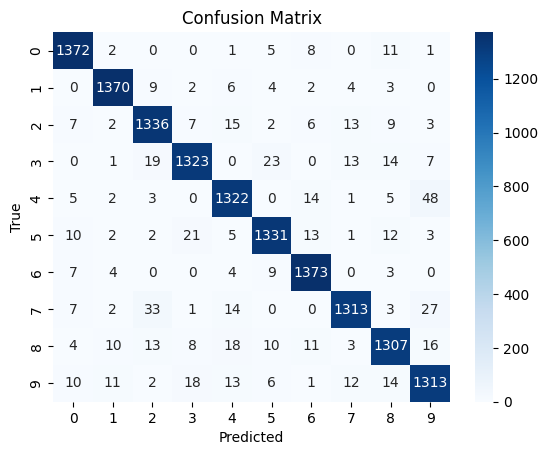

In [ ]:
confusionMatrix(Y_test, Y_test_pred)

In [ ]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1400
           1       0.97      0.98      0.98      1400
           2       0.94      0.95      0.95      1400
           3       0.96      0.94      0.95      1400
           4       0.95      0.94      0.94      1400
           5       0.96      0.95      0.95      1400
           6       0.96      0.98      0.97      1400
           7       0.97      0.94      0.95      1400
           8       0.95      0.93      0.94      1400
           9       0.93      0.94      0.93      1400

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000



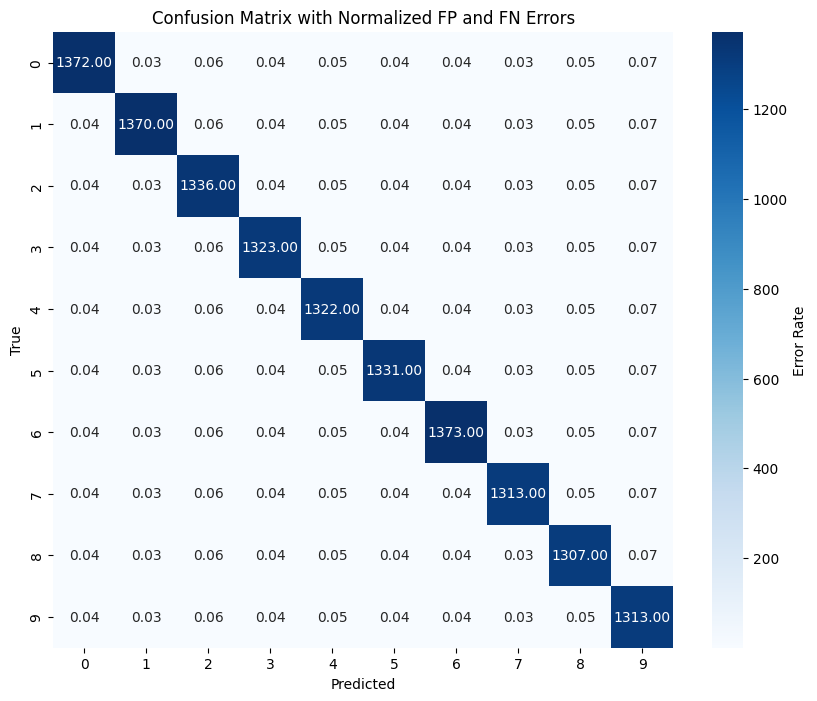

In [ ]:
confusionMatrixWithNormalizedErrors(Y_test, Y_test_pred)

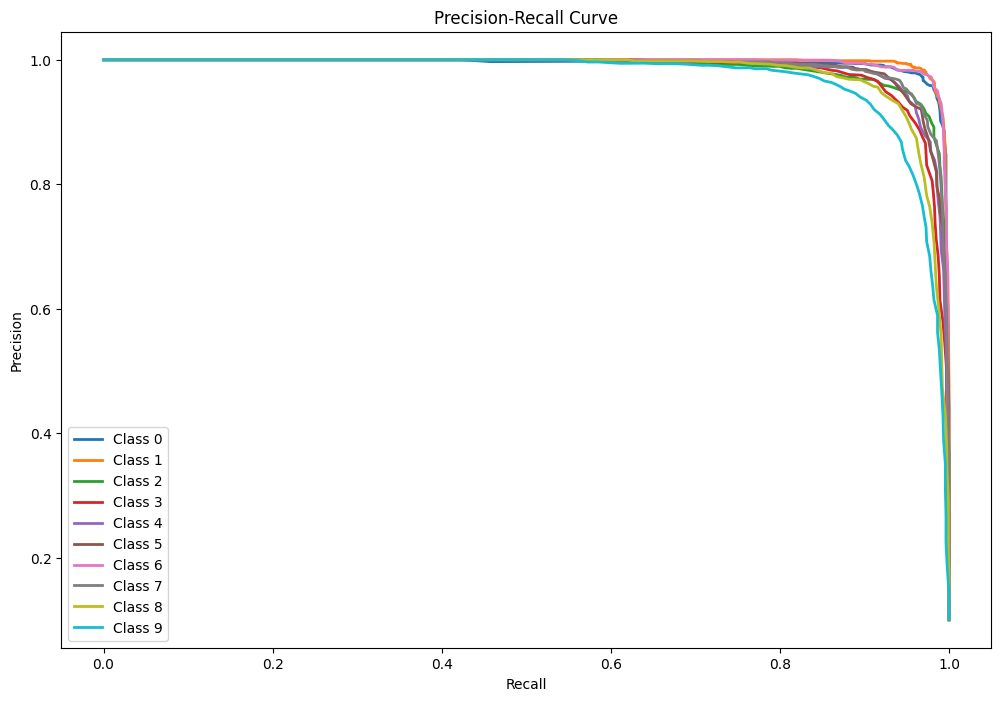

In [ ]:
plot_pr_curve(Y_test, y_test_prob, 10)

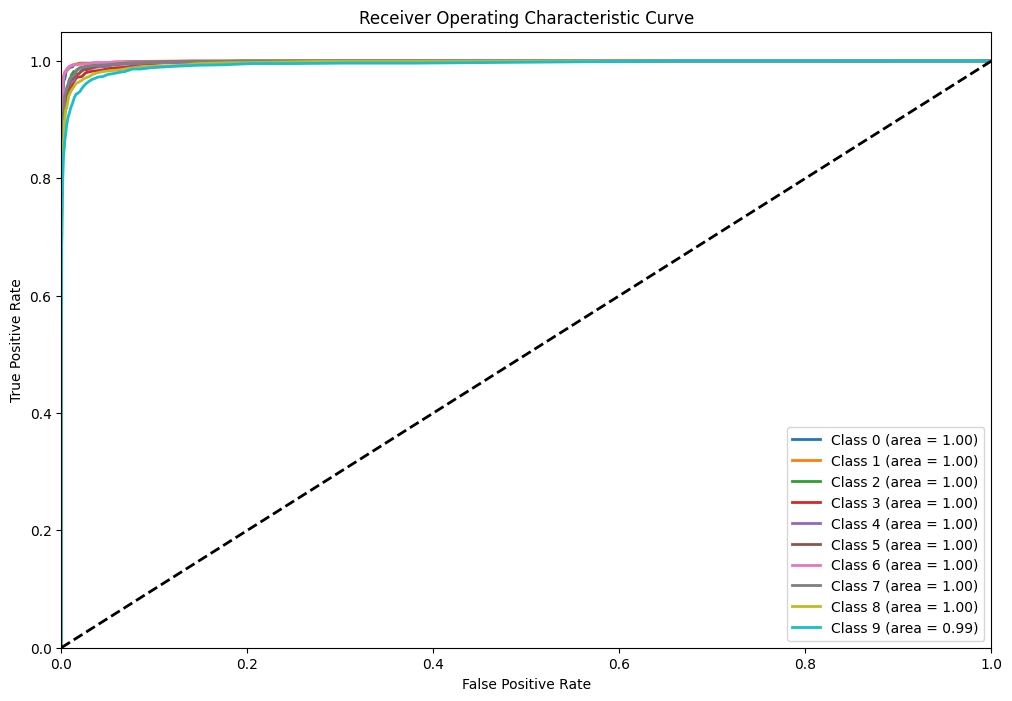

In [ ]:
plot_roc_curve(Y_test, y_test_prob, 10)

In [ ]:
cat = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
cat.fit(X_train, Y_train.values.ravel())

Y_train_pred = cat.predict(X_train)
print(f"Training Accuracy = {accuracy_score(Y_train, Y_train_pred)}")

y_test_prob = cat.predict_proba(X_test)
Y_test_pred = cat.predict(X_test)
print(f"Testing Accuracy = {accuracy_score(Y_test, Y_test_pred)}")

Training Accuracy = 0.9619642857142857
Testing Accuracy = 0.9376428571428571


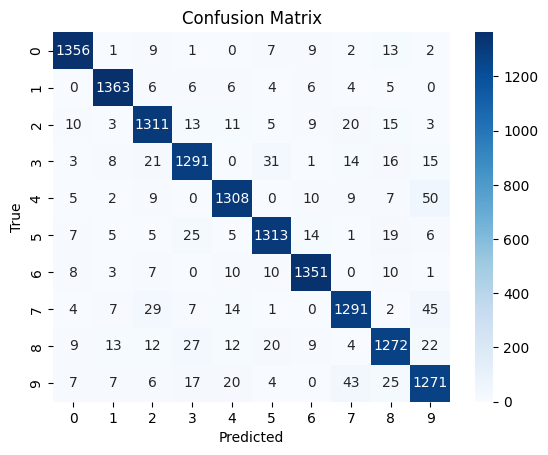

In [ ]:
confusionMatrix(Y_test, Y_test_pred)

In [ ]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1400
           1       0.97      0.97      0.97      1400
           2       0.93      0.94      0.93      1400
           3       0.93      0.92      0.93      1400
           4       0.94      0.93      0.94      1400
           5       0.94      0.94      0.94      1400
           6       0.96      0.96      0.96      1400
           7       0.93      0.92      0.93      1400
           8       0.92      0.91      0.91      1400
           9       0.90      0.91      0.90      1400

    accuracy                           0.94     14000
   macro avg       0.94      0.94      0.94     14000
weighted avg       0.94      0.94      0.94     14000



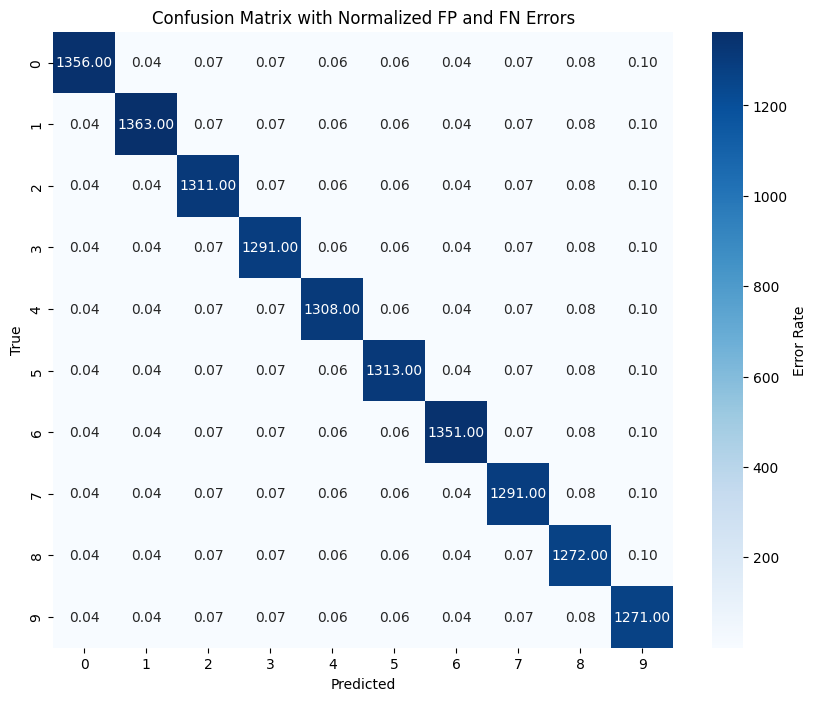

In [ ]:
confusionMatrixWithNormalizedErrors(Y_test, Y_test_pred)

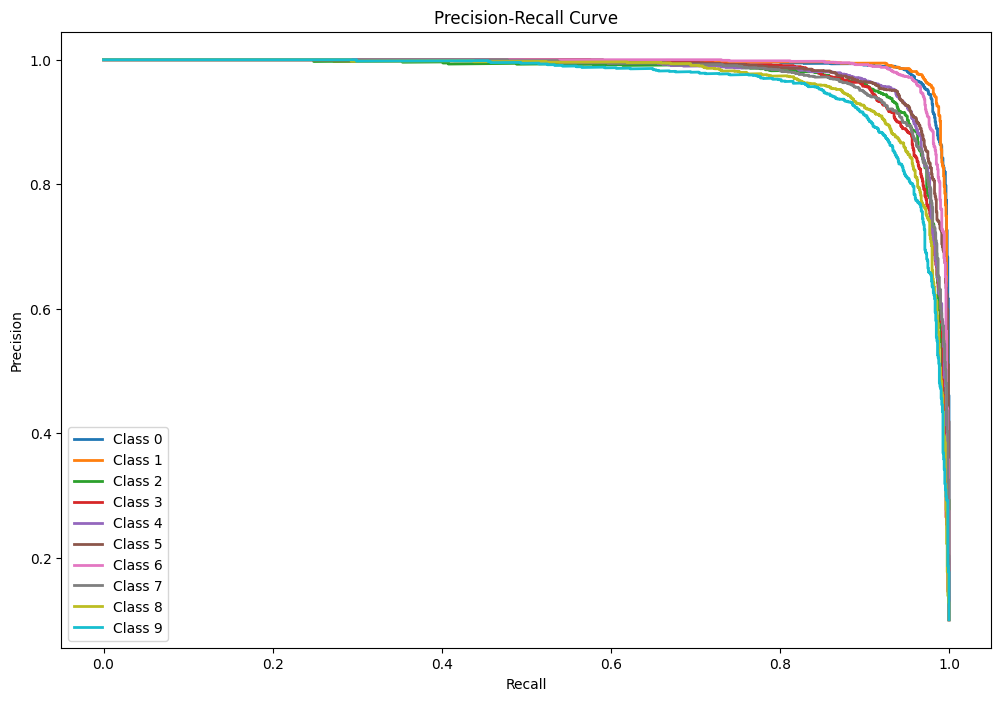

In [ ]:
plot_pr_curve(Y_test, y_test_prob, 10)

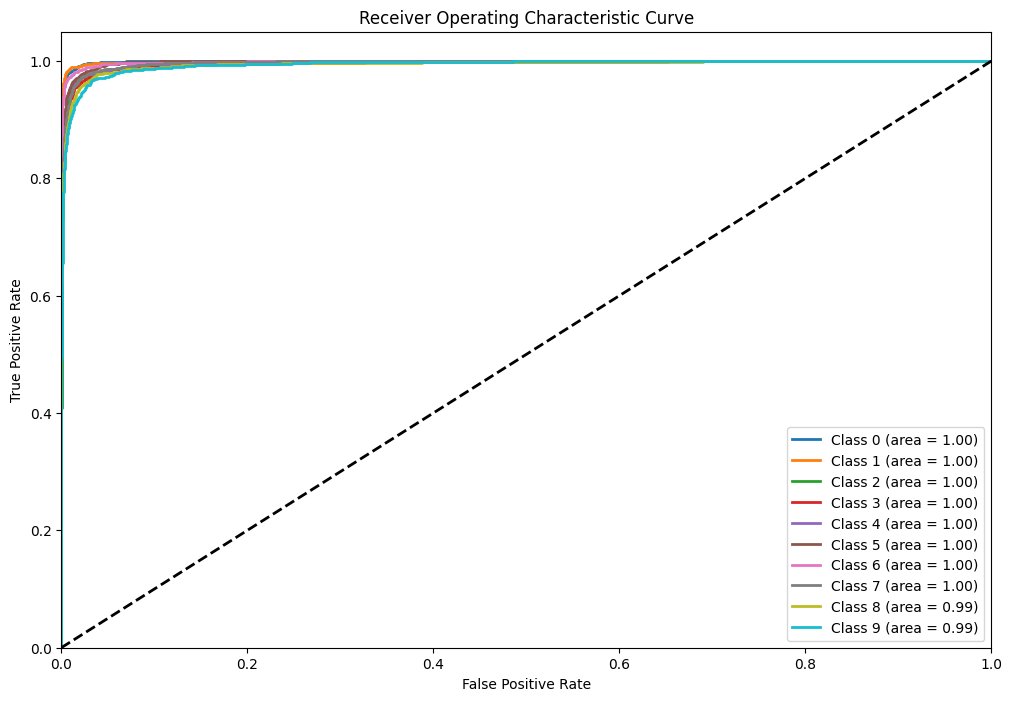

In [ ]:
plot_roc_curve(Y_test, y_test_prob, 10)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=3000, learning_rate_init = 0.001, alpha = 2 , learning_rate = 'adaptive', hidden_layer_sizes = (100, 100, 50))
mlp.fit(X_train, Y_train.values.ravel())

Training_pred_mpl= mlp.predict(X_train)
print(f"Training Accuracy = {accuracy_score(Y_train, Training_pred_mpl)}")

y_test_prob = mlp.predict_proba(X_test)
Testing_pred_mlp = mlp.predict(X_test)
print(f"Testing Accuracy = {accuracy_score(Y_test, Testing_pred_mlp)}")

Training Accuracy = 0.94975
Testing Accuracy = 0.9392857142857143


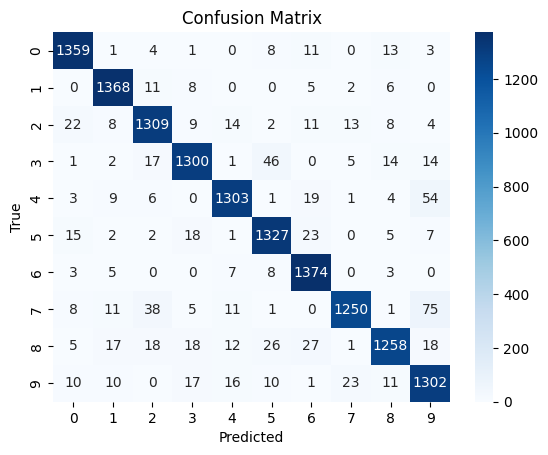

In [ ]:
confusionMatrix(Y_test, Testing_pred_mlp)

In [ ]:
print(classification_report(Y_test, Testing_pred_mlp))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1400
           1       0.95      0.98      0.97      1400
           2       0.93      0.94      0.93      1400
           3       0.94      0.93      0.94      1400
           4       0.95      0.93      0.94      1400
           5       0.93      0.95      0.94      1400
           6       0.93      0.98      0.96      1400
           7       0.97      0.89      0.93      1400
           8       0.95      0.90      0.92      1400
           9       0.88      0.93      0.91      1400

    accuracy                           0.94     14000
   macro avg       0.94      0.94      0.94     14000
weighted avg       0.94      0.94      0.94     14000



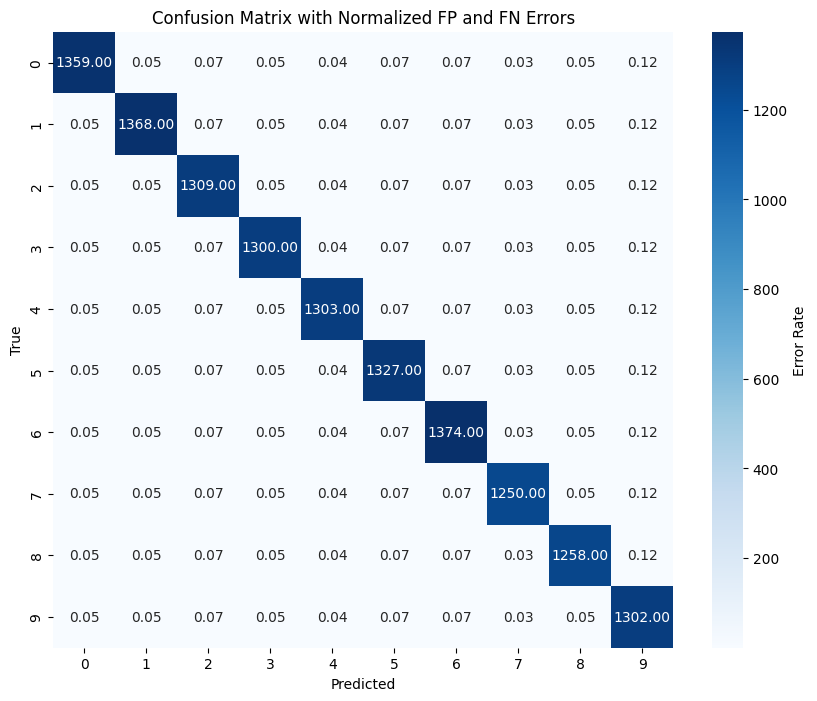

In [ ]:
confusionMatrixWithNormalizedErrors(Y_test, Testing_pred_mlp)

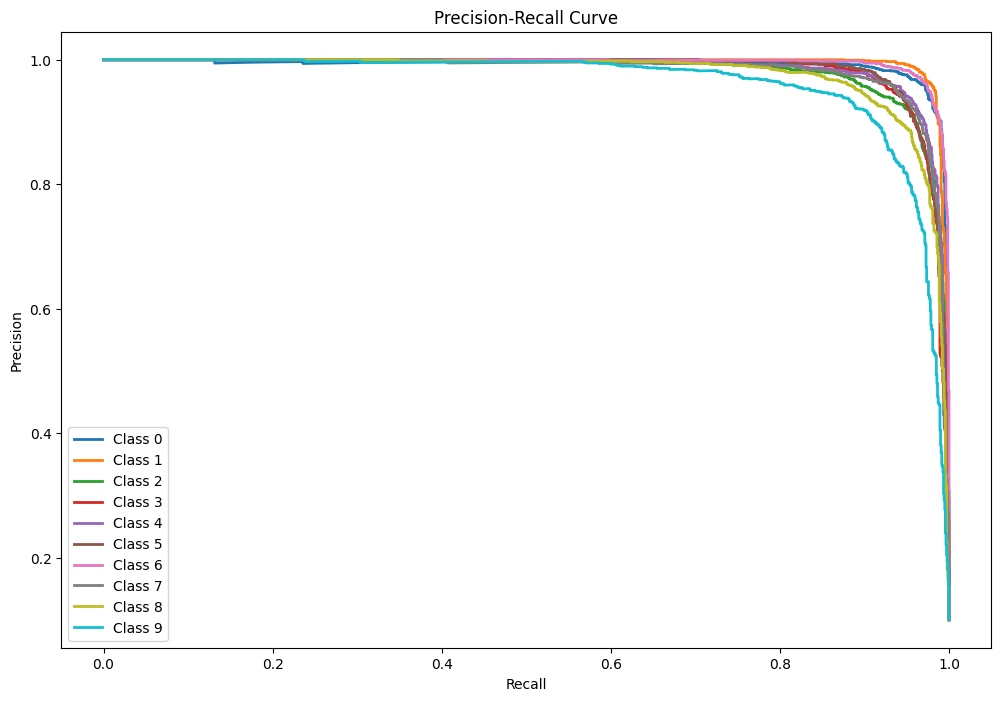

In [ ]:
plot_pr_curve(Y_test, y_test_prob, 10)

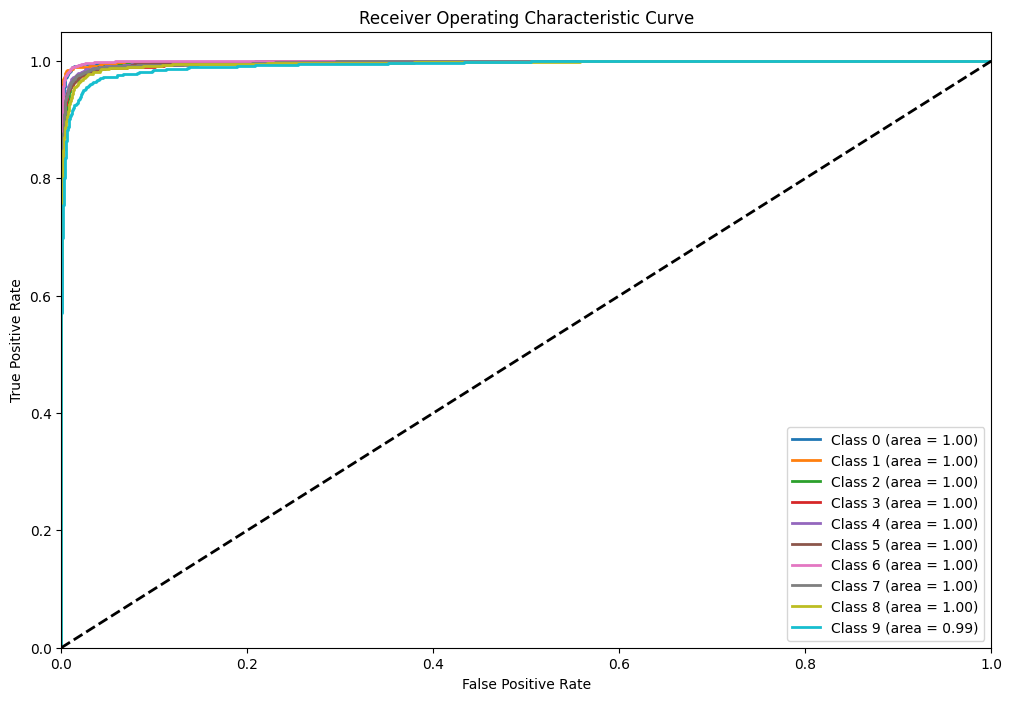

In [ ]:
plot_roc_curve(Y_test, y_test_prob, 10)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=3000, learning_rate_init = 0.001, alpha = 2 , learning_rate = 'adaptive', hidden_layer_sizes = (100, 100, 100))
mlp.fit(X_train, Y_train.values.ravel())

Training_pred_mpl= mlp.predict(X_train)
print(f"Training Accuracy = {accuracy_score(Y_train, Training_pred_mpl)}")

y_test_prob = mlp.predict_proba(X_test)
Testing_pred_mlp = mlp.predict(X_test)
print(f"Testing Accuracy = {accuracy_score(Y_test, Testing_pred_mlp)}")

Training Accuracy = 0.9513392857142857
Testing Accuracy = 0.9447142857142857


Train Test Validation Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_undersampled, Y_undersampled, test_size = 0.4, stratify=Y_undersampled, random_state = 0)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.4, stratify=Y_test, random_state = 0)

In [ ]:
X_train.shape

(120000, 784)

In [ ]:
Y_train.value_counts()

target
0         12000
1         12000
2         12000
3         12000
4         12000
5         12000
6         12000
7         12000
8         12000
9         12000
Name: count, dtype: int64

In [ ]:
clf_cat = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
clf_cat.fit(X_train, Y_train)

Y_train_pred = clf_cat.predict(X_train)
Y_val_pred = clf_cat.predict(X_val)
Y_test_pred = clf_cat.predict(X_test)


train_accuracy = accuracy_score(Y_train, Y_train_pred)
val_accuracy = accuracy_score(Y_val, Y_val_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)


Y_test_prob = clf_cat.predict_proba(X_test)


print("Training Accuracy = ",train_accuracy)
print("Validation Accuracy = ",val_accuracy)
print("Testing Accuracy = ",test_accuracy)

Training Accuracy =  0.9621916666666667
Validation Accuracy =  0.95053125
Testing Accuracy =  0.9495625


In [ ]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4800
           1       0.97      0.97      0.97      4800
           2       0.94      0.94      0.94      4800
           3       0.95      0.93      0.94      4800
           4       0.94      0.95      0.95      4800
           5       0.95      0.94      0.95      4800
           6       0.96      0.97      0.97      4800
           7       0.95      0.95      0.95      4800
           8       0.93      0.94      0.93      4800
           9       0.92      0.93      0.93      4800

    accuracy                           0.95     48000
   macro avg       0.95      0.95      0.95     48000
weighted avg       0.95      0.95      0.95     48000



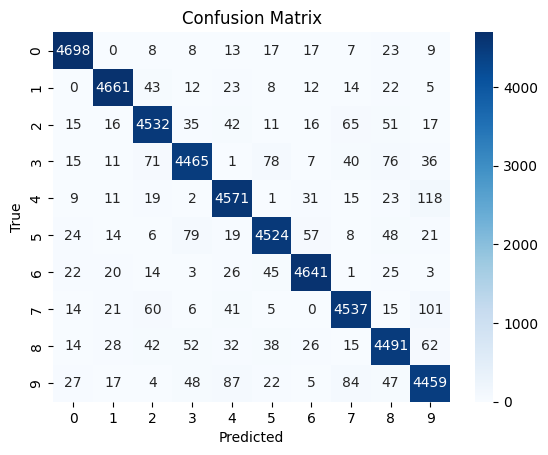

In [ ]:
confusionMatrix(Y_test, Y_test_pred)